In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

sns.set_style("whitegrid")

## Objective

In [2]:
def create_objective(target: float = 0.45):
    def objective(b):
        return (b - target) ** 2
    return objective

<Axes: >

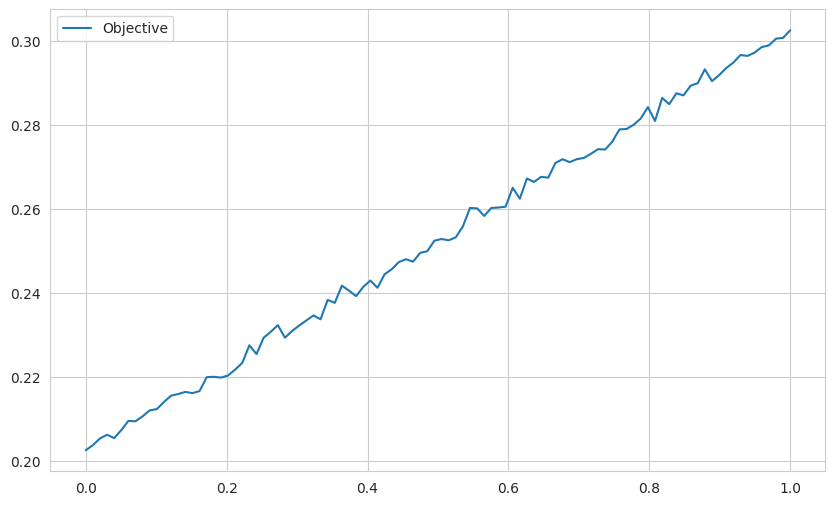

In [3]:
thetas = torch.linspace(0, 1, 100)
evals = 1000
objective = create_objective()

results = []
for theta in thetas:
    theta = torch.tensor([theta] * evals)
    betas = torch.bernoulli(theta)
    results.append(objective(betas).mean().item())

# plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=thetas.numpy(), y=results, label="Objective")

## Helpers for REBAR

In [4]:
def log_pb_bern(b, theta):
    """ Log probability of Bernoulli distribution. """
    return torch.log(theta) * b + torch.log(1 - theta) * (1 - b)

b = torch.tensor([1])
theta = torch.tensor([0.43], requires_grad=True)
log_pb_value = log_pb_bern(b, theta)

autograd.grad(log_pb_value, theta)

(tensor([2.3256]),)

In [5]:
def g(u, theta):
    """ 
    Differentiable reparametrization of z.

    Givem u ~ U(0, 1), and theta from (0, 1).
    Return a sample from p(z). Logistic distribution.
    """
    return torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))


def g_tilde(v, b, theta):
    """
    Differentiable reparametrization of z|b.

    Given v ~ U(0, 1), b ~ Bernoulli(theta).
    and theta from (0, 1).

    Return a sample from the distribution p(z|b).
    """
    zb1 = torch.log((v / (1 - v)) * (1/(1-theta)) + 1)
    zb0 = -torch.log((v / (1 - v)) * (1/theta) + 1)
    return torch.where(b == 1, zb1, zb0)


def H(z):
    """
    The hard threshold function.
    """
    return torch.where(z >= 0, 1, 0)


def sigma(z, lmbda = 1):
    """
    Sigmoid with a temperature parameter.
    """
    return torch.sigmoid(z / lmbda)


def g_lmbda(u, theta, lmbda = 1):
    """
    Differentiable reparametrization of z_lmbda.

    After sigma this makes an alternative to sigma(g(u, theta), lmbda).
    lmbda must be the same for both g_lmbda and sigma.
    """
    quadratic = (lmbda**2 + lmbda + 1)/(lmbda + 1)
    z_lmbda = quadratic * torch.log(theta / (1 - theta)) + torch.log(u / (1 - u))
    return z_lmbda

## Manual SGD with fiex $\lambda$ and $\eta$

  6%|▋         | 319/5000 [00:00<00:02, 1873.26it/s]


NaN detected


<Axes: >

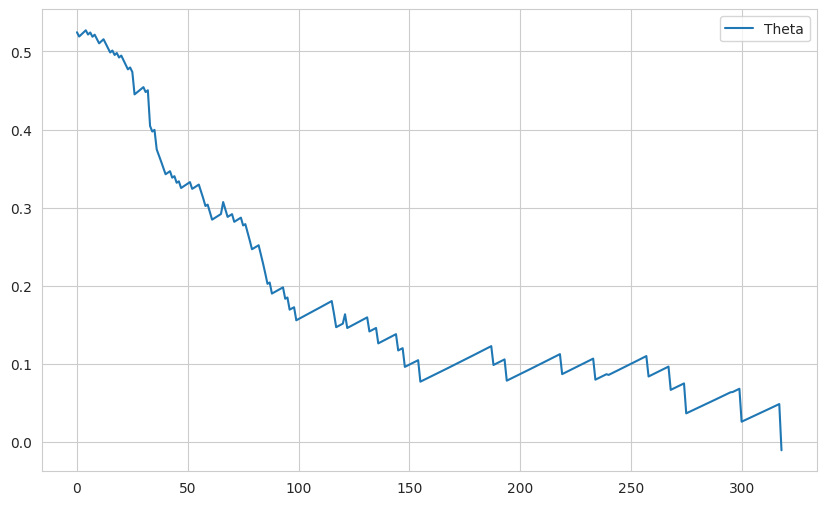

In [6]:
lmbda = 0.01
lr = 0.01
max_iter = 5000

n = 1
f = create_objective(target=0.4)
log_pb = log_pb_bern


thetas = []
estimates = []

eta = 0.2
theta = torch.tensor([0.53], requires_grad=True)

for _ in tqdm(range(max_iter)):

    estimate = torch.zeros(theta.shape)
    for _ in range(n):
        u, v = torch.rand(2, 1)
        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)

        grad_log_pb = autograd.grad(log_pb(b, theta), theta)[0]
        first_term = ((f(b) - eta * f(sigma(z_tilde, lmbda))) * grad_log_pb).detach()
        second_term = eta * autograd.grad(f(sigma(z, lmbda)), theta)[0].detach()
        thrid_term = -eta * autograd.grad(f(sigma(z_tilde, lmbda)), theta)[0].detach()
        estimate += first_term + second_term + thrid_term

    estimate /= n

    if torch.isnan(estimate).any():
        print("NaN detected")
        break

    theta = (lr * (-estimate) + theta).detach() # SGD step
    # theta = torch.clamp(theta, 0.01, 0.99)
    thetas.append(theta.item())
    theta.requires_grad = True

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta")
sns.lineplot(x=range(len(estimates)), y=estimates, label="Estimate")

## Implementation with any torch optimizer

100%|██████████| 5000/5000 [00:05<00:00, 897.85it/s] 


<Axes: >

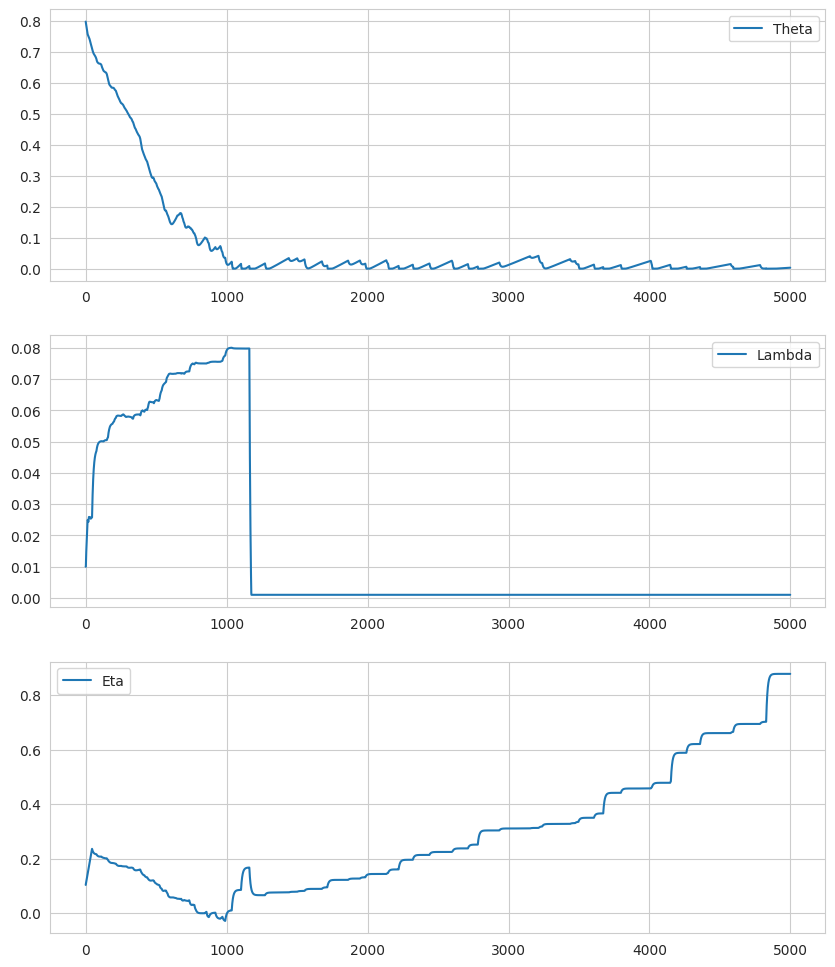

In [7]:
lr = 0.003
max_iter = 5000

n = 1
f = create_objective(target=0.4)
log_pb = log_pb_bern

lmbda = torch.tensor([0.01], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta, lmbda, eta], lr=lr, betas=(0.9, 0.99999))

thetas = []
lmbdas = []
etas = []
loss = []

for _ in tqdm(range(max_iter)):

    opt.zero_grad()

    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)

        z = g(u, theta)
        b = H(z).detach()
        z_tilde = g_tilde(v, b, theta)

        first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
        second_term = eta * f(sigma(z, lmbda))
        thrid_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + thrid_term

    loss /= n

    grad_estimate = autograd.grad(loss, theta, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))
    theta.grad = grad_estimate.detach()

    # torch.nn.utils.clip_grad_norm_([theta, lmbda, eta], 100.0, norm_type="inf")

    opt.step()

    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    lmbda.data = torch.clamp(lmbda.data, 0.001)

    if torch.isnan(theta).any():
        print("NaN detected")
        break

    thetas.append(theta.item())
    lmbdas.append(lmbda.item())
    etas.append(eta.item())

# Create a plot with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta", ax=axs[0])
sns.lineplot(x=range(len(lmbdas)), y=lmbdas, label="Lambda", ax=axs[1])
sns.lineplot(x=range(len(etas)), y=etas, label="Eta", ax=axs[2])


## Implementation with quadratic relaxation from Appendix E

100%|██████████| 5000/5000 [00:08<00:00, 577.16it/s]


<Axes: >

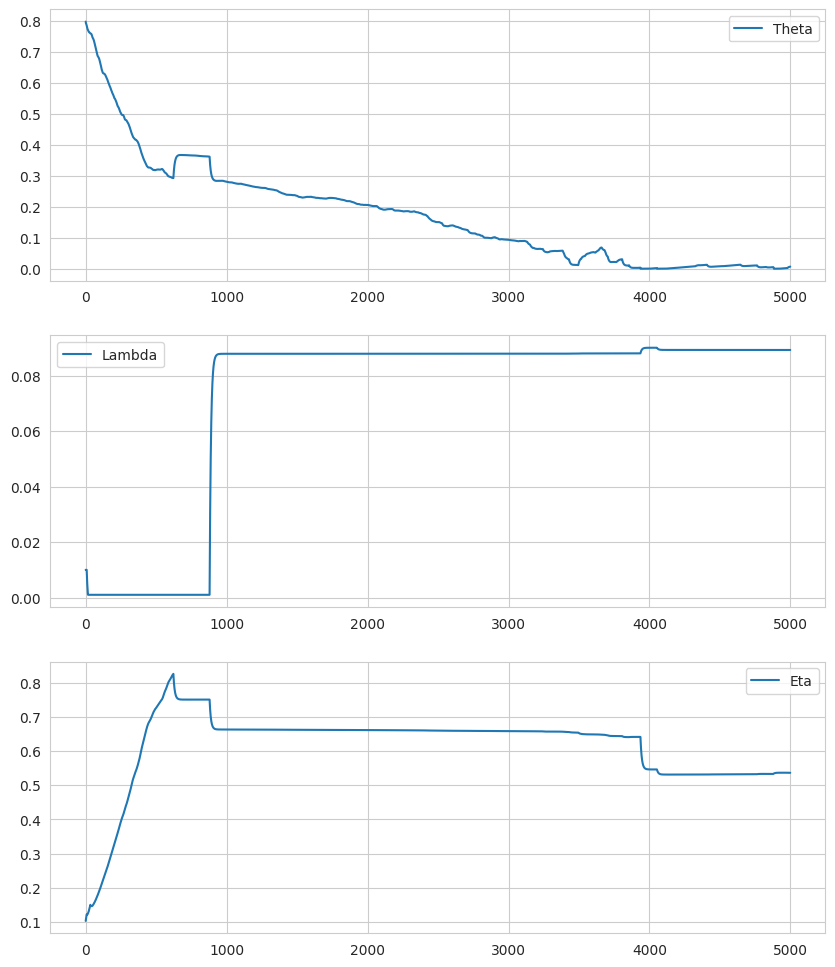

In [8]:
lr = 0.003
max_iter = 5000

n = 1
f = create_objective(target=0.4)
log_pb = log_pb_bern

lmbda = torch.tensor([0.01], requires_grad=True)
eta = torch.tensor([0.1], requires_grad=True)
theta = torch.tensor([0.8], requires_grad=True)

opt = torch.optim.Adam([theta, lmbda, eta], lr=lr, betas=(0.9, 0.99999))

thetas = []
lmbdas = []
etas = []

for _ in tqdm(range(max_iter)):

    opt.zero_grad()

    loss = 0
    for _ in range(n):
        u, v = torch.rand(2, 1)

        z_lmbda = g_lmbda(u, theta, lmbda)
        b = H(z_lmbda).detach()
        z_tilde = g_tilde(v, b, theta)

        first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, theta)
        second_term = eta * f(sigma(z_lmbda, lmbda))
        thrid_term = -eta * f(sigma(z_tilde, lmbda))
        loss += first_term + second_term + thrid_term

    loss /= n

    grad_estimate = autograd.grad(loss, theta, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))
    theta.grad = grad_estimate.detach()

    # torch.nn.utils.clip_grad_norm_([theta, lmbda, eta], 100.0, norm_type="inf")

    opt.step()

    theta.data = torch.clamp(theta.data, 0.001, 0.999)
    lmbda.data = torch.clamp(lmbda.data, 0.001)

    if torch.isnan(theta).any():
        print("NaN detected")
        break

    thetas.append(theta.item())
    lmbdas.append(lmbda.item())
    etas.append(eta.item())

# Create a plot with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
sns.lineplot(x=range(len(thetas)), y=thetas, label="Theta", ax=axs[0])
sns.lineplot(x=range(len(lmbdas)), y=lmbdas, label="Lambda", ax=axs[1])
sns.lineplot(x=range(len(etas)), y=etas, label="Eta", ax=axs[2])